In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Examining the Data

In [2]:
# read the data
users_data = pd.read_pickle("../data/users_data_final.pkl")


In [3]:
# preview the data

users_data.head(n = 3)

,user_id,number_transactions,total_amount_usd,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,term_deposit,date_joined,device
0,9231c446-cb16-4b2b-a7f7-ddfc8b25aaf6,3.0,2143.0,58,management,married,tertiary,False,True,False,None,261,1,-1,0,None,False,1998-08-23,mobile
1,bb92765a-08de-4963-b432-496524b39157,NaN,NaN,44,technician,single,secondary,False,True,False,None,151,1,-1,0,None,False,2008-07-15,desktop
2,573de577-49ef-42b9-83da-d3cfb817b5c1,2.0,2.0,33,entrepreneur,married,secondary,False,True,True,None,76,1,-1,0,None,False,2002-06-04,mobile


In [4]:
# check the shape of the data

users_data.shape

(45209, 19)

In [5]:
print("# of rows:", users_data.shape[0])
print("# of columns:", users_data.shape[1])


# of rows: 45209
# of columns: 19


In [6]:
# check the structure of the data

users_data.info()

# remind yourself how many variables with data type object

<class 'pandas.core.frame.DataFrame'>
Index: 45209 entries, 0 to 45215
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45209 non-null  object        
 1   number_transactions  35210 non-null  float64       
 2   total_amount_usd     35210 non-null  float64       
 3   age                  45209 non-null  int64         
 4   job                  44921 non-null  object        
 5   marital              45209 non-null  object        
 6   education            43352 non-null  object        
 7   default              45209 non-null  bool          
 8   housing              45209 non-null  bool          
 9   loan                 45209 non-null  bool          
 10  contact              32191 non-null  object        
 11  duration             45209 non-null  int64         
 12  campaign             45209 non-null  int64         
 13  pdays                45209 non-null 

### 1. Feature Selection

In [7]:
# which features do we want to drop, since they will not be useful to building a ML model?

# let's start with user_id and date_joined 

users_data_cleaned = users_data.drop(['date_joined', 'user_id'], axis = 1)

In [8]:
# Identify correlated features

users_data_cleaned.corr(numeric_only = True)

# Do we have any highly correlated fetaures i.e. correlations above 0.9 or below -0.9?


,number_transactions,total_amount_usd,age,default,housing,loan,duration,campaign,pdays,previous,term_deposit
number_transactions,1.000000,-0.163409,-0.008813,0.138838,0.030429,0.075319,-0.017220,0.026431,-0.030751,-0.023046,-0.053390
total_amount_usd,-0.163409,1.000000,0.095839,-0.065390,-0.066857,-0.084526,0.022586,-0.017274,0.006435,0.016952,0.050785
age,-0.008813,0.095839,1.000000,-0.017875,-0.185552,-0.015641,-0.004645,0.004767,-0.023745,0.001297,0.025168
default,0.138838,-0.065390,-0.017875,1.000000,-0.006020,0.077232,-0.010017,0.016819,-0.029982,-0.018331,-0.022421
housing,0.030429,-0.066857,-0.185552,-0.006020,1.000000,0.041341,0.005041,-0.023583,0.124197,0.037087,-0.139161
loan,0.075319,-0.084526,-0.015641,0.077232,0.041341,1.000000,-0.012395,0.009972,-0.022762,-0.011048,-0.068193
duration,-0.017220,0.022586,-0.004645,-0.010017,0.005041,-0.012395,1.000000,-0.084551,-0.001549,0.001213,0.394549
campaign,0.026431,-0.017274,0.004767,0.016819,-0.023583,0.009972,-0.084551,1.000000,-0.088636,-0.032860,-0.073179
pdays,-0.030751,0.006435,-0.023745,-0.029982,0.124197,-0.022762,-0.001549,-0.088636,1.000000,0.454817,0.103616
previous,-0.023046,0.016952,0.001297,-0.018331,0.037087,-0.011048,0.001213,-0.032860,0.454817,1.000000,0.093232


In [9]:
# definition to identify and remove correlated variables

def identify_highly_correlated_features(df, correlation_threshold):
    """
    This definition can be used to identify highly correlated features
    
    @param df pandas DataFrame
    @param correlation_threshold int 
    
    @return a DataFrame with highly correlated features 
    """
    
    corr_matrix = df.corr(numeric_only = True).abs() # calculate the correlation matrix with 
    high_corr_var = np.where(corr_matrix >= correlation_threshold) # identify variables that have correlations above defined threshold
    high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y], round(corr_matrix.iloc[x, y], 2))
                         for x, y in zip(*high_corr_var) if x != y and x < y] # identify pairs of highly correlated variables
    
    high_corr_var_df = pd.DataFrame(high_corr_var).rename(columns = {0: 'corr_feature',
                                                                     1: 'drop_feature',
                                                                     2: 'correlation_values'})

    
    if high_corr_var_df.empty:
        high_corr_var_df
    else:
        high_corr_var_df = high_corr_var_df.sort_values(by = 'correlation_values', ascending = False)

    return high_corr_var_df
    


In [10]:
# this will help identify pairs of correlated features

identify_highly_correlated_features(users_data_cleaned, correlation_threshold=0.9)


""


In [11]:
# identify and remove features with low standard deviation

users_data_cleaned.describe()

# question: do we have have any features with std less than 1?


,number_transactions,total_amount_usd,age,duration,campaign,pdays,previous
count,35210.000000,35210.000000,45209.000000,45209.000000,45209.000000,45209.000000,45209.000000
mean,3.977052,1369.417751,40.935853,258.153067,2.763897,40.199651,0.580349
std,3.814329,3063.412688,10.618653,257.525446,3.098076,100.130586,2.303489
min,1.000000,-8019.000000,18.000000,0.000000,1.000000,-1.000000,0.000000
25%,2.000000,73.000000,33.000000,103.000000,1.000000,-1.000000,0.000000
50%,3.000000,451.000000,39.000000,180.000000,2.000000,-1.000000,0.000000
75%,4.000000,1438.000000,48.000000,319.000000,3.000000,-1.000000,0.000000
max,20.000000,102127.000000,95.000000,4918.000000,63.000000,871.000000,275.000000


### 2. Handling Missing Data

In [12]:
users_data_cleaned.isnull().sum()

# how many features have missing values?
# what should we do?

number_transactions     9999
total_amount_usd        9999
age                        0
job                      288
marital                    0
education               1857
default                    0
housing                    0
loan                       0
contact                13018
duration                   0
campaign                   0
pdays                      0
previous                   0
poutcome               36957
term_deposit               0
device                    94
dtype: int64

In [13]:
def identify_missing_data(df):
    """
    This function is used to identify missing data
    
    @param df pandas DataFrame
    
    @return a DataFrame with the percentage of missing data for every feature and the data types
    """
    
    percent_missing = df.isnull().mean()
    
    missing_value_df = pd.DataFrame(percent_missing).reset_index() # convert to DataFrame
    missing_value_df = missing_value_df.rename(columns = {"index" : "feature",
                                                                0 : "percent_missing"}) # rename columns

    missing_value_df = missing_value_df.sort_values(by = ['percent_missing'], ascending = False) # sort the values
    
    data_types_df = pd.DataFrame(df.dtypes).reset_index().rename(columns = {"index" : "feature",
                                                                0 : "data_type"}) # rename columns
    
    missing_value_df = missing_value_df.merge(data_types_df, on = "feature") # join the dataframe with datatype
    
    missing_value_df.percent_missing = round(missing_value_df.percent_missing*100, 2) # format the percent_missing
    
    return missing_value_df[missing_value_df.percent_missing > 0]

In [14]:
# use definition to produce a DataFrame that summarises missing data

missing_df = identify_missing_data(users_data_cleaned)
missing_df

,feature,percent_missing,data_type
0,poutcome,81.75,object
1,contact,28.80,object
2,number_transactions,22.12,float64
3,total_amount_usd,22.12,float64
4,education,4.11,object
5,job,0.64,object
6,device,0.21,object


In [15]:
print("number of features with missing data:", missing_df.shape[0])

number of features with missing data: 7


In [16]:
# where more than 40% missing data drop this feature

feature_to_drop = list(missing_df[missing_df.percent_missing > 40].feature)
users_data_cleaned = users_data_cleaned.drop(feature_to_drop, axis = 1)

In [17]:
# check this was dropped

missing_df = identify_missing_data(users_data_cleaned)
missing_df


,feature,percent_missing,data_type
0,contact,28.80,object
1,number_transactions,22.12,float64
2,total_amount_usd,22.12,float64
3,education,4.11,object
4,job,0.64,object
5,device,0.21,object


In [18]:
# if feature has data type object and missing values, fill with Unknown

users_data_cleaned['contact'].fillna("Unknown", inplace = True)
users_data_cleaned['education'].fillna("Unknown", inplace = True)
users_data_cleaned['job'].fillna("Unknown", inplace = True)
users_data_cleaned['device'].fillna("Unknown", inplace = True)

In [19]:
# check this was correctly filled

users_data_cleaned['job'].value_counts(dropna = False)

job
blue-collar      9731
management       9457
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
Unknown           288
Name: count, dtype: int64

In [20]:
users_data_cleaned['job'].value_counts(dropna = False)

job
blue-collar      9731
management       9457
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
Unknown           288
Name: count, dtype: int64

In [21]:
# check this was dropped

missing_df = identify_missing_data(users_data_cleaned)
missing_df


,feature,percent_missing,data_type
0,number_transactions,22.12,float64
1,total_amount_usd,22.12,float64


In [22]:
# if feature has data type float and missing values, fill with 0

users_data_cleaned['number_transactions'].fillna(0, inplace = True)
users_data_cleaned['total_amount_usd'].fillna(0, inplace = True)

In [23]:
# check we have no more missing data

missing_df = identify_missing_data(users_data_cleaned)
missing_df

,feature,percent_missing,data_type


### 6. Encoding Variables

In [24]:
# we have no missing data yay, but do we have any non numrical data types left?

users_data_cleaned.info()

# we have five objects, so we need to encode them

<class 'pandas.core.frame.DataFrame'>
Index: 45209 entries, 0 to 45215
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   number_transactions  45209 non-null  float64
 1   total_amount_usd     45209 non-null  float64
 2   age                  45209 non-null  int64  
 3   job                  45209 non-null  object 
 4   marital              45209 non-null  object 
 5   education            45209 non-null  object 
 6   default              45209 non-null  bool   
 7   housing              45209 non-null  bool   
 8   loan                 45209 non-null  bool   
 9   contact              45209 non-null  object 
 10  duration             45209 non-null  int64  
 11  campaign             45209 non-null  int64  
 12  pdays                45209 non-null  int64  
 13  previous             45209 non-null  int64  
 14  term_deposit         45209 non-null  bool   
 15  device               45209 non-null  obje

In [25]:
# before encoding check the number of categories of 
# you want to avoid encoding features with too many categories. 

categories = (users_data_cleaned.select_dtypes("object")
            .apply(pd.Series.nunique)
            .sort_values(ascending=False))
        
categories

# credit for this code goes to one of my previous students, Terje


job          12
education     4
device        4
marital       3
contact       3
dtype: int64

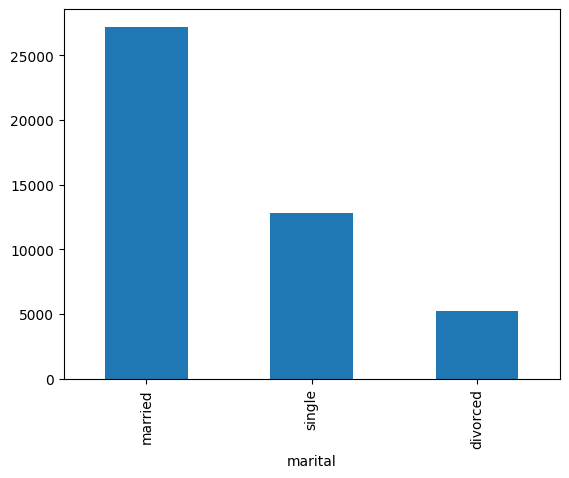

In [26]:
# look at the distribution of one of the categorical variables and see if the output makes sense

users_data_cleaned.marital.value_counts().plot(kind = 'bar');

In [27]:
# you may want to drop catgeorical features where number_categories is greater than 10

users_data_cleaned.drop(['job'], axis = 1, inplace = True)

In [28]:
# the rest we will encode by applying one hot encoding and using get_dummies

pd.get_dummies(users_data_cleaned['marital'], prefix='marital')

,marital_divorced,marital_married,marital_single
0,False,True,False
1,False,False,True
2,False,True,False
3,False,True,False
4,False,False,True
...,...,...,...
45211,False,True,False
45212,True,False,False
45213,False,True,False
45214,False,True,False


In [29]:
def one_hot(df, categorical_cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    
    for c in categorical_cols:
        dummies = pd.get_dummies(df[c], prefix=c)
        df = pd.concat([df, dummies], axis=1)
        df.drop(c, axis = 1, inplace = True)
    
    return df

In [30]:
# encode all of the categorical columns

categorical_columns = list(users_data_cleaned.select_dtypes(['object']).columns)

users_data_cleaned_w_encoding = one_hot(users_data_cleaned, categorical_columns)

In [31]:
# check shape of new data - we have ten new columns
print(users_data_cleaned.shape)
print(users_data_cleaned_w_encoding.shape)

(45209, 15)
(45209, 25)


In [32]:
users_data_cleaned_w_encoding.head()

,number_transactions,total_amount_usd,age,default,housing,loan,duration,campaign,pdays,previous,...,education_primary,education_secondary,education_tertiary,contact_Unknown,contact_cellular,contact_telephone,device_Unknown,device_desktop,device_mobile,device_tablet
0,3.0,2143.0,58,False,True,False,261,1,-1,0,...,False,False,True,True,False,False,False,False,True,False
1,0.0,0.0,44,False,True,False,151,1,-1,0,...,False,True,False,True,False,False,False,True,False,False
2,2.0,2.0,33,False,True,True,76,1,-1,0,...,False,True,False,True,False,False,False,False,True,False
3,0.0,0.0,47,False,True,False,92,1,-1,0,...,False,False,False,True,False,False,False,False,False,True
4,1.0,1.0,33,False,False,False,198,1,-1,0,...,False,False,False,True,False,False,False,False,True,False


In [33]:
# one last check - do we have any missing data or non numerical data?

users_data_cleaned_w_encoding.info()

# let's continue....

<class 'pandas.core.frame.DataFrame'>
Index: 45209 entries, 0 to 45215
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   number_transactions  45209 non-null  float64
 1   total_amount_usd     45209 non-null  float64
 2   age                  45209 non-null  int64  
 3   default              45209 non-null  bool   
 4   housing              45209 non-null  bool   
 5   loan                 45209 non-null  bool   
 6   duration             45209 non-null  int64  
 7   campaign             45209 non-null  int64  
 8   pdays                45209 non-null  int64  
 9   previous             45209 non-null  int64  
 10  term_deposit         45209 non-null  bool   
 11  marital_divorced     45209 non-null  bool   
 12  marital_married      45209 non-null  bool   
 13  marital_single       45209 non-null  bool   
 14  education_Unknown    45209 non-null  bool   
 15  education_primary    45209 non-null  bool

In [34]:
users_data_cleaned_w_encoding.to_pickle("../data/users_data_cleaned.pkl")

### Feature Scaling

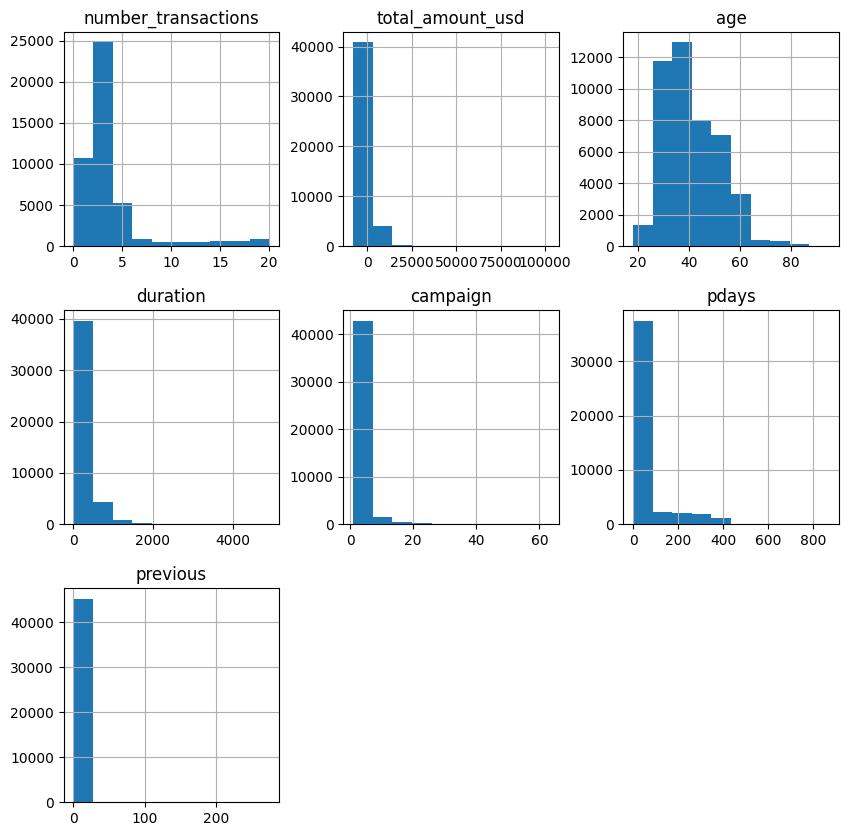

In [35]:
# last thing to do before building our ML model.......

# depending what algorithm we decide to use, we may need to scale the data

# let's say we are building our first Linear Regression Model, where we want to predict number of transactions a new user may have
# we need to scale the data


users_data_cleaned_w_encoding.hist(figsize=(10, 10));

# check the distribution of data


In [36]:
# split the data into features and targets

target = users_data_cleaned_w_encoding.total_amount_usd
features = users_data_cleaned_w_encoding.drop(['total_amount_usd'], axis = 1)


In [37]:
# since our target is a continuous variables we use a regression algorithm

target.describe()

count     45209.000000
mean       1066.539826
std        2762.588385
min       -8019.000000
25%           0.000000
50%         211.000000
75%        1022.000000
max      102127.000000
Name: total_amount_usd, dtype: float64

In [38]:
# since most of our features are heavily skewed we will use normalisation to scale the data
# import MinMaxScaler from scikitlearn

from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)

features_scaled


array([[0.15      , 0.51948052, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.33766234, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.1       , 0.19480519, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.1       , 0.7012987 , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.50649351, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.15      , 0.24675325, 0.        , ..., 0.        , 1.        ,
        0.        ]])

### Building the ML model

In [39]:
# split our data into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_scaled,
                                                    target,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [40]:
# print the shape of the training data

print("Training Data")
print(X_train.shape)
print(y_train.shape)

Training Data
(36167, 24)
(36167,)


In [41]:
# print the shape of the test data

print("Test Data")
print(X_test.shape)
print(y_test.shape)

Test Data
(9042, 24)
(9042,)


In [42]:
# Import the Linear Regression model from sklearn

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [43]:
# training the model

lr.fit(X_train, y_train)

LinearRegression()

In [44]:
# make predictions on unseen data

y_pred = lr.predict(X_test)
y_pred

array([1558.61989119, 1359.27080495, 1385.46244087, ...,  878.85328331,
       1115.32011105, 1378.58758521])

In [45]:
print("first five predicted total amounts:", y_pred[0:5])
print("first five actual total amounts:", list(y_test[0:5]))

first five predicted total amounts: [1558.61989119 1359.27080495 1385.46244087  986.87570111 1158.62233235]
first five actual total amounts: [536.0, 31.0, 19.0, 115.0, 0.0]


In [46]:
# evaluate how the model is performing

from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

# Pretty close to 0, which means the features do not explain the target

0.023366706338686316

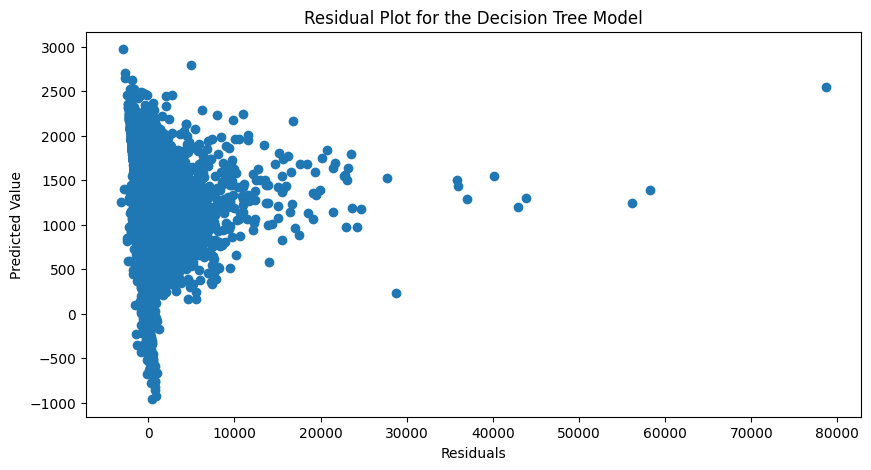

In [47]:
# residual plot - shows where all the error lies

plt.rcParams["figure.figsize"] = (10,5)

residuals = y_test - y_pred

plt.scatter(residuals, y_pred)
plt.title("Residual Plot for the Decision Tree Model")
plt.xlabel("Residuals")
plt.ylabel("Predicted Value")
plt.show();

# we want them the points to be centred around 0